


# Introduction to $\chi^2$ Fitting

chi-squared (χ²) fitting is one of the most fundamental statistical methods in experimental high energy physics. The method quantifies how well a proposed model describes the observed measurements.

## Mathematical Definition

The chi-squared statistic is defined as:

$$\chi^2 = \sum_{i=1}^{N} \frac{(y_i - f(x_i; \theta))^2}{\sigma_i^2}$$

Where:
- **N** = number of data points
- **y_i** = observed value at point i
- **f(x_i; θ)** = theoretical prediction from model with parameters θ
- **σ_i** = uncertainty (error) on measurement y_i

## Physical Interpretation

- **Numerator (y_i - f(x_i; θ))²**: Squared difference between data and theory
- **Denominator σ_i²**: Normalizes by measurement uncertainty
- **Sum**: Combines information from all data points


## Key Concepts

### Best-Fit Parameters
The optimal parameters θ̂ minimize χ²:
$$\hat{\theta} = \arg\min_{\theta} \chi^2(\theta)$$

### Goodness of Fit
The reduced chi-squared indicates fit quality:
$$\chi^2_{\text{red}} = \frac{\chi^2}{\text{degrees of freedom}}$$

- χ²/ndf ≈ 1: Good fit
- χ²/ndf >> 1: Poor fit or underestimated errors  
- χ²/ndf << 1: Overestimated errors

### Parameter Uncertainties
Error estimates come from the curvature of χ² at its minimum, encoded in the covariance matrix.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

/Users/xxiang/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


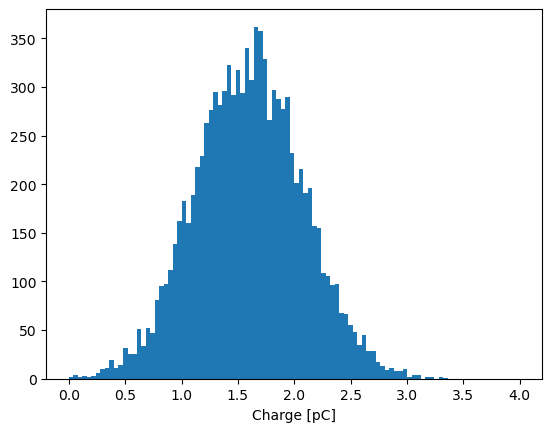

In [2]:
# generate fake data
s = np.random.normal(loc=1.6, scale=1.6*0.3, size=10000)
ydata, xbin, p = plt.hist(s, bins=100, range=(0,4));
plt.xlabel('Charge [pC]')
xdata = (xbin[1:]+xbin[:-1])*0.5

In [3]:
# define Gaussian
def gaus(x, A, mu, sigma):
  arg = (x-mu)/sigma
  return A*np.exp(-0.5*arg*arg)

In [4]:
# do chi2 fit in a range. We avoid low statistics bin for chi2 fit. This is generally true as chi2 fit does not do well when statistics is low. 
xmin = 0.5
xmax = 2.5
mask = (xdata>xmin) & (xdata<xmax)
xdata = xdata[mask]
ydata = ydata[mask]
sigma = np.sqrt(ydata)

popt, pcov = curve_fit(gaus, xdata, ydata, sigma=sigma)
print('Best fit parameters:', popt)
print('Covariance Matrix:\n', pcov)

Best fit parameters: [334.84799452   1.59809737   0.47099092]
Covariance Matrix:
 [[ 3.05097441e+01 -3.15307527e-03 -2.19656827e-02]
 [-3.15307527e-03  4.69495110e-05  8.04014224e-06]
 [-2.19656827e-02  8.04014224e-06  3.92542194e-05]]


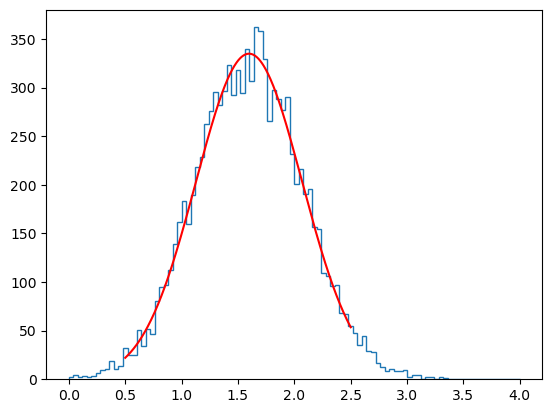

In [5]:
plt.hist(s, bins=100, range=(0,4), histtype='step');

x = np.linspace(xmin, xmax, 400)
y = gaus(x, popt[0], popt[1], popt[2])
plt.plot(x, y, color='r');

In [6]:
def calc_chi2(func, popt, xdata, ydata, sigma):
  ymodel = func(xdata, popt[0], popt[1], popt[2])
  res = ydata-ymodel 
  chi2 = np.square(res/sigma)
  return np.sum(chi2)

def calc_reduced_chi2(func, popt, xdata, ydata, sigma):
  npar = len(popt) # num of free parameters
  dof = len(xdata) - npar
  return calc_chi2(func, popt, xdata, ydata, sigma)/dof


print('Your chi2 is:', calc_chi2(gaus, popt, xdata, ydata, sigma))
print('Your reduced chi2 is:', calc_reduced_chi2(gaus, popt, xdata, ydata, sigma))

Your chi2 is: 70.64484472109426
Your reduced chi2 is: 1.5357574939368317


In [7]:
# compute standard error from the fit
err = np.diag(pcov)
err = np.sqrt(err)
print("A: %.3e +/- %.3e" % (popt[0], err[0]))
print("mu: %.3e +/- %.3e" % (popt[1], err[1]))
print("sigma: %.3e +/- %.3e" % (popt[2], err[2]))

A: 3.348e+02 +/- 5.524e+00
mu: 1.598e+00 +/- 6.852e-03
sigma: 4.710e-01 +/- 6.265e-03


---

# Part 2: Chi² Fitting with iminuit

## Why iminuit?

- **Professional tool**: Used in major HEP experiments (LHC, etc.)
- **Better error handling**: Automatic error propagation and correlations
- **Advanced features**: Contour plots, profile likelihood, constraints


In [41]:
# Install iminuit if not available

try:
    from iminuit import Minuit
    from iminuit.cost import LeastSquares
    print("✓ iminuit successfully imported")
except ImportError:
    print("❌ iminuit not found. Please install with: pip install iminuit")
    raise

# Reuse the same data from previous example
# Apply same range selection
mask = (xdata > xmin) & (xdata < xmax)
x_fit = xdata[mask]
y_fit = ydata[mask]
yerr_fit = sigma[mask]


✓ iminuit successfully imported


In [42]:
# Define model function for iminuit
def gaussian_model(x, amplitude, mean, sigma):
    """Gaussian model for fitting"""
    return amplitude * np.exp(-0.5 * ((x - mean) / sigma)**2)

# Set up chi² cost function
chi2_cost = LeastSquares(x_fit, y_fit, yerr_fit, gaussian_model)

# Create Minuit object with initial parameter guesses
m = Minuit(chi2_cost, amplitude=300, mean=1.6, sigma=0.5)

# Set parameter limits (optional but recommended)
m.limits['amplitude'] = (0, None)      # Amplitude must be positive
m.limits['sigma'] = (0.01, None)       # Width must be positive

print("Initial parameters:")
print(m.values)
print(m.errors)


Initial parameters:
<ValueView amplitude=300.0 mean=1.6 sigma=0.5>
<ErrorView amplitude=3.0 mean=0.016 sigma=0.005>


In [43]:
# Perform the fit
m.migrad()  # Main minimization algorithm

# Check fit status
print("Fit converged:", m.valid)
print("Chi² =", m.fval)
print("Reduced chi² =", m.fval / m.ndof)
print("Number of degrees of freedom =", m.ndof)

print("\n=== FITTED PARAMETERS ===")
for param in m.parameters:
    val = m.values[param]
    err = m.errors[param]
    print(f"{param:10s}: {val:8.4f} ± {err:8.4f}")

print(f"\nCovariance matrix:")
print(m.covariance)


Fit converged: True
Chi² = 70.64495916205398
Reduced chi² = 1.5357599817837821
Number of degrees of freedom = 46.0

=== FITTED PARAMETERS ===
amplitude : 334.8026 ±   4.4312
mean      :   1.5981 ±   0.0055
sigma     :   0.4710 ±   0.0050

Covariance matrix:
┌───────────┬──────────────────────────────────┐
│           │  amplitude       mean      sigma │
├───────────┼──────────────────────────────────┤
│ amplitude │       19.6  -2.291e-3 -13.910e-3 │
│      mean │  -2.291e-3   3.08e-05   0.006e-3 │
│     sigma │ -13.910e-3   0.006e-3   2.49e-05 │
└───────────┴──────────────────────────────────┘



## Plot the fit PDF along with the propagated error band on the data

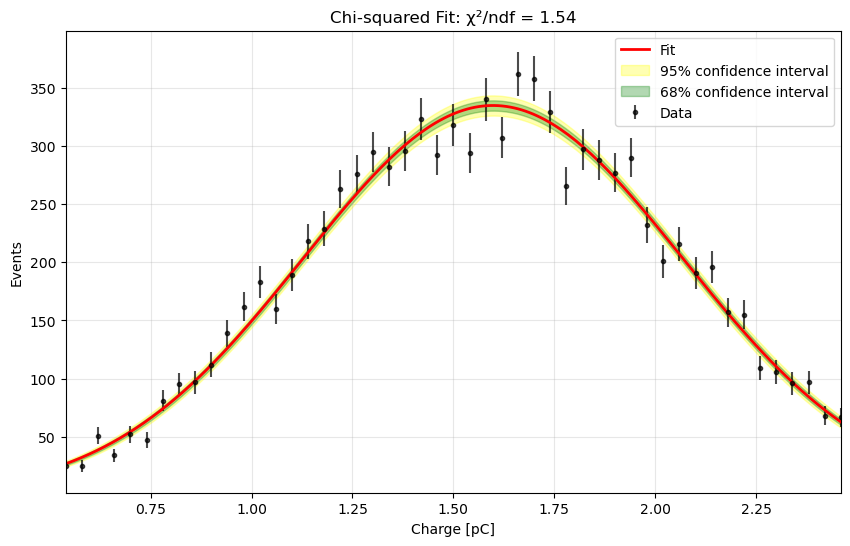

In [51]:
# Calculate error band using error propagation
def calculate_error_band(x, amplitude, mean, sigma, cov_matrix):
    """Calculate 68% confidence interval for Gaussian model using error propagation"""
    # Partial derivatives of the Gaussian model with respect to each parameter
    def partial_amplitude(x, amp, mu, sig):
        return np.exp(-0.5 * ((x - mu) / sig)**2)
    
    def partial_mean(x, amp, mu, sig):
        return amp * np.exp(-0.5 * ((x - mu) / sig)**2) * (x - mu) / (sig**2)
    
    def partial_sigma(x, amp, mu, sig):
        return amp * np.exp(-0.5 * ((x - mu) / sig)**2) * ((x - mu)**2) / (sig**3)
    
    # Calculate partial derivatives at each x point
    dA = partial_amplitude(x, amplitude, mean, sigma)
    dmu = partial_mean(x, amplitude, mean, sigma)
    dsig = partial_sigma(x, amplitude, mean, sigma)
    
    # Stack derivatives into Jacobian matrix (n_points × 3)
    jacobian = np.array([dA, dmu, dsig]).T
    
    # Calculate variance at each point: J * Cov * J^T
    variance = np.sum((jacobian @ cov_matrix) * jacobian, axis=1)
    
    return np.sqrt(variance)

# Plot with error band
plt.figure(figsize=(10, 6))
plt.errorbar(x_fit, y_fit, yerr_fit, fmt='ko', markersize=3, alpha=0.7, label='Data')

x_smooth = np.linspace(xdata[0], xdata[-1], 200)
y_smooth = gaussian_model(x_smooth, m.values['amplitude'], m.values['mean'], m.values['sigma'])

# Calculate error bands for both 68% and 95% confidence intervals
cov_matrix = m.covariance
y_error_68 = calculate_error_band(x_smooth, m.values['amplitude'], m.values['mean'], m.values['sigma'], cov_matrix)
y_error_95 = 1.96 * y_error_68  # 95% confidence interval (approximately 2 sigma)

# Plot fit and error bands
plt.plot(x_smooth, y_smooth, 'r-', linewidth=2, label='Fit')
plt.fill_between(x_smooth, y_smooth - y_error_95, y_smooth + y_error_95, 
                 alpha=0.3, color='yellow', label='95% confidence interval')
plt.fill_between(x_smooth, y_smooth - y_error_68, y_smooth + y_error_68, 
                 alpha=0.3, color='green', label='68% confidence interval')

plt.xlabel('Charge [pC]')
plt.ylabel('Events')
plt.xlim(xdata[0], xdata[-1])
plt.title(f'Chi-squared Fit: χ²/ndf = {m.fval/m.ndof:.2f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


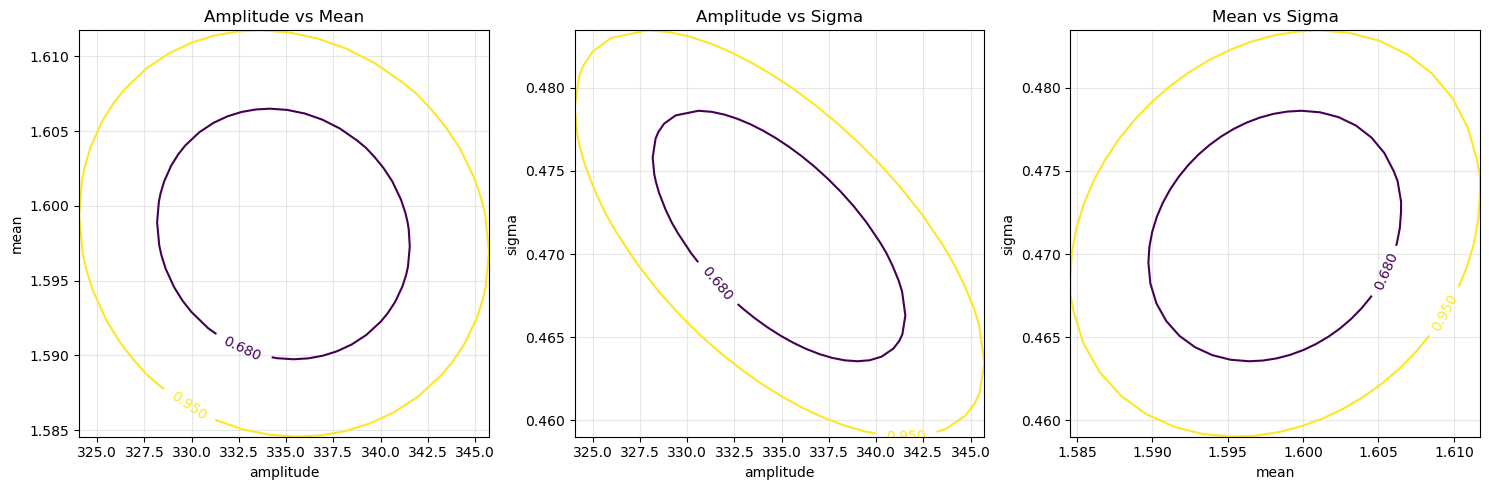

In [49]:
# Create a new figure for contour plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot contours for each pair of parameters
# Amplitude vs Mean
plt.sca(axes[0])
m.draw_mncontour('amplitude', 'mean', size=50, cl=[0.68, 0.95])
axes[0].set_title('Amplitude vs Mean')
axes[0].grid(True, alpha=0.3)

# Amplitude vs Sigma
plt.sca(axes[1])
m.draw_mncontour('amplitude', 'sigma', size=50, cl=[0.68, 0.95])
axes[1].set_title('Amplitude vs Sigma')
axes[1].grid(True, alpha=0.3)

# Mean vs Sigma
plt.sca(axes[2])
m.draw_mncontour('mean', 'sigma', size=50, cl=[0.68, 0.95])
axes[2].set_title('Mean vs Sigma')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
